In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import decimal
from scipy.stats import norm
from itertools import product
import random
from scipy.stats import truncnorm
from itertools import combinations

### Fonctions générales:

$\to$ On définit la fonction $W(n,P)$ qui génère une matrice $(W_{i,k})$ générée suivant une loi donnée centrée réduite avec $W^i_0 = 0$.



$\to$ On définit la fonction $\texttt{gen_X}(n,X_0,\sigma,\lambda, \delta,P, W)$ qui étant donné à un vecteur à $n$ dimensions de départ $X_0$ simule $P$ pas des actifs $X(P\delta) = (X_1(P\delta), \cdots, X_n(P\delta))$ où l'équation d'évolution est la suivante:
$$X_i(t_{k+1}) = X_i(t_k)e^{-\lambda \delta} + \mu(1-e^{-\lambda \delta})+ \sqrt{\delta} \sigma W_{i,k}  \text{ (équation 1)}$$

$\to$ Pour le cas particulier de $W_k^i$ i.i.d et suit la loi gaussienne centrée réduite, on fait la remarque que pour $k\in [|1,n|]$ et un temps $t_P = T$, $X_k(t_P)$ est somme de gaussiennes indépendantes, on déduit que $X_k(t_P)$ est aussi une variable gaussienne. Les caractéristiques de cette gaussienne se déduisent aisément par la relation de récurrence de l'équations $(1)$, pour $N\in \textbf{N}$, en notant $\mu_{N,k}$ la moyenne de cette gaussienne et $\sigma_{P,k}$ sa variance:
$$\begin{cases}
\mu_{P,k} = e^{-\lambda \delta}\mu + \mu(1-e^{-\lambda \delta})\\
\sigma_{P,k}^2 = e^{-2\lambda\delta}\sigma_{P-1,k}^2+ \delta \sigma^2 
\end{cases}
$$

On résout aisément, on trouve:
$$\mu_{P,k}  = \mu\text{ , }\sigma_{P,k}^2 = r(1-e^{-2P\lambda \delta}) \text{ où }r  =\dfrac{\delta \sigma^2}{1-e^{-2\lambda \delta}}$$
$\to$ On définit alors la fonction $\texttt{gen_X_particulier}(X_0,P,n,\sigma,\lambda, \delta)$ qui renvoie directement le résultat au temps $T$ d'une simulation.


On définit la fonction $\texttt{insolvance_1}(v, C)$ qui étant donné un vecteur $v =X(T)$ des actifs à l'écheance, renvoie la liste des banque insolvante. On fait la remarque suivante:
$$D_{k}^T = D_{k-1}^T\cup ( D_{k}^T -  D_{k-1}^T)$$

$\to$ On définit la fonction impact $I(X_0,P\propto T, F,R)$ où $F$ est le résultat de insolvance_1.

In [142]:
X_0 + np.random.normal(size = (10,5))

array([[14.99995294, 15.72691214, 15.12648307, 14.57319775, 13.97369013],
       [15.93925068, 16.02072038, 14.58714518, 15.3687409 , 14.13546947],
       [15.81876151, 13.81581   , 15.82047355, 14.35080338, 14.8197711 ],
       [15.33244124, 15.51442267, 16.31787899, 14.69090005, 16.38653869],
       [14.45830414, 16.46536721, 15.77688632, 15.06651681, 13.95439334],
       [13.67230976, 14.58130842, 13.60866955, 15.02511675, 13.04049493],
       [13.16453861, 16.64706524, 15.93611546, 14.0035279 , 13.64786627],
       [14.15663056, 14.30475851, 15.73967766, 14.6878415 , 14.91624089],
       [15.37755627, 15.57748129, 13.62662448, 14.87203298, 16.21959021],
       [15.41838327, 15.2490268 , 15.13389702, 14.99256197, 13.65524902]])

In [2]:
#####Fonctions générales
def W_1(n,P = 365):
    W_1 = np.random.randn(n,P)
    W_1[:, 0]= 0
    return W_1

def gen_X(X_0, W,P = 365, n =5, sigma = 8, lbda = 20, delta =1/365):
    A = np.full((n,P),0.0)
    A[:,0] = X_0
    for p in range(1,P):
        A[:,p] =A[:,p-1]*np.exp(-lbda*delta) + X_0*(1- np.exp(-lbda*delta))+np.sqrt(delta)*sigma *W[:,p]
    return A

def gen_X_particulier(X_0,N=1, sigma_2 = 1.689):
    return X_0+np.sqrt(sigma_2)*np.random.normal(size = (N,n))

def insolvance_1(E,v, C, R = 0.05):
    assert len(v) == len(C)
    assert E.shape[0] == len(v) and E.shape[1] == len(v)
    used_up = np.full(len(v),False)
    l=-1
    while True:
        used_up+= v<C
        v = (v - (1-R)*np.sum(E*(used_up), axis = 1))*(v>=C)
        if (l == np.sum(used_up)):
            break
        l = np.sum(used_up)
    return used_up

def I(X,F,R = 0.05, P = 365):
    return np.sum((X + (1-R)*np.sum(E[~F], axis = 0))*(F))

vectorized_impact = np.vectorize(I, signature='(n),(n)->()')

def calculate_var_cvar(impacts, alpha):
    sorted_impacts=np.sort(impacts)
    #calculons value-at_risk
    var_index=int((1 - alpha) * len(sorted_impacts))
    var=sorted_impacts[var_index]
    #Conditional VAR
    cvar = np.mean(sorted_impacts[var_index:])
    return var, cvar

def adapted_impact(x, F):
    return I(x,F)  +np.sum(mu-x[~F]) 

vectorized_adapted_impact = np.vectorize(adapted_impact, signature='(n),(n)->()')


def transformation_sur_quantile(x,quantile,rho,M):
    rho_bar=np.sqrt(1-rho**2)
    y=np.random.randn(M,len(x))
    for i in range(M):
        xtilde = rho*x+sigma*rho_bar*y[i]+mu*(1-rho)
        F=insolvance_1(E,xtilde,C,R)
        si=adapted_impact(xtilde, F)>quantile
        x = xtilde*(si) + x*(not si)
    return x
def NiveauxSplitting(a, seuil ,M, C , E, rho = 0.6, N = 10000, R = 0.05):
    X = gen_X_particulier(X_0,N)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
    impacts = vectorized_adapted_impact(X, insolvances)
    #I_brut=impacts.copy() #On conserve la liste I non-triée
    #impacts.sort()
    sorts = np.argsort(impacts)
    quantiles = []
    indice = int(np.ceil((1-seuil)*N))-1
    quantiles.append(impacts[sorts[indice]])
    quantile=quantiles[-1]
    while quantiles[-1] < a:
        initial=len(X)
        indices = impacts>quantiles[-1] 
        X = X[indices]
        try:
            choix = np.random.randint(0,len(X),size = initial-len(X))
        except:
            break
        sous_X = X[choix]
        Z = np.apply_along_axis(lambda v: transformation_sur_quantile(v, quantiles[-1], rho, M), axis=1, arr=sous_X)
        #Z= [transformation_sur_quantile(x, quantiles[-1], rho, M) for x in sous_X]
        X = np.concatenate((X, Z), axis=0)  
        insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
        cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
        impacts = vectorized_adapted_impact(X, insolvances)
        indice=int(np.ceil((1-seuil)*N))-1
        sorts = np.argsort(impacts)
        quantiles = np.append(quantiles, impacts[sorts[indice]])
    ## On rajoute a
    niveaux = np.append(quantiles, a)
    ## Dernière probabilité :
    plast = np.mean(impacts>a)
    return niveaux, plast



## Premier modèle: Capitaux indépendants

On s'interesse au calcul de différents quantités probabilisites relatifs aux $X_i$. On utilise les différents méthodes de simulations exposés lors des cours magistraux:

$\to$ Méthode de Monte-Carlo Naif.

$\to$ Méthode d'échantillonage d'importance.

$\to$ Méthode MCMC.

On estime les quantités suivantes:

$\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$, la probabilité qu'on a insolvance d'exactement $k$ banques.

$\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

$\to$ Distribution de l’impact de défaut conditionnellement à l'effondrement du réseaux tout entier.

Pour ce cas particulier, $\textbf{ on utilise que les valeurs finaux de $X$}$, on se sert alors de la fonction $\texttt{gen_X_particulier}$.

#### Paramètres du modèle

On prend $n=5$. On se sert de la fonction $\texttt{gen_X_particulier}$. Plus tard on prend des valeurs assez grande de $n$.

In [3]:
####Constantes
N = 100000 #nombres de simulations
sigma = 8
lbda = 20
delta =1/365

In [4]:
## Hypothèse du premier modèle:
n = 5 
P = 365
sigma_2 = delta*sigma**2 *(1-np.exp(-2*P*lbda*delta)) /(1-np.exp(-2*lbda*delta) )
R = 0.05
E = np.array([[0,3,0,0,6],
              [3,0,0,0,0],
              [3,3,0,0,0],
              [2,2,2,0,2],
              [0,2,3,3,0]])

mu = 15. ## commune
c = 10 ## commune
X_0 = np.full(n,mu)
C = np.full(n,c)

In [6]:
#Génération de de trajectoire de $n = 5$ banques entre $t=0$ et $t=T$
W = W_1(n)
X = gen_X(X_0,W)

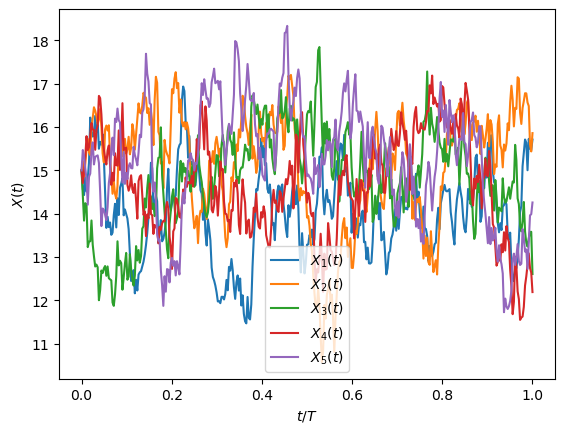

In [22]:
#Visualisation
base = np.linspace(0,1, num =X.shape[1])
for j in range(X.shape[0]):
    plt.plot(base,X[j,:], label = '$X_'+str(j+1)+'(t)$')
plt.xlabel("$t/T$")
plt.ylabel('$X(t)$')
leg = plt.legend(loc=0)
plt.show()

## $\blacktriangleright$ Monte-Carlo Naif

In [23]:
## Génération de $N$ trajectoires de $X$.
echantillons = gen_X_particulier(X_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
impacts = vectorized_impact(echantillons, insolvances)

### $\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$.

On a $|D_n^T|= |D_n^T|(X)$ et donc pour des $(X_i)$ i.i.d, on a à $k$ fixé par TCL+Slutsky et LFN:
$$\overline{c}_k^N = \dfrac{1}{N}\sum_{k=1}^N \overbrace{\textbf{1}_{|D_n^T|(X_i)= k}}^{\text{i.i.d dans }\{0,1\}\text{, admet donc tous moment}}\xrightarrow[N\to +\infty]{}\textbf{P}(|D_n^T|(X)= k) =p_k$$
$$\dfrac{\sqrt{N}}{\sqrt{\overline{c}_k^N (1-\overline{c}_k^N)}}(\overline{c}_k^N - p_k)\xrightarrow[N\to +\infty]{\mathcal{L}}\mathcal{N}(0,1)$$
On obtient un intervalle de confiance, en notant $q$ la quantile d'ordre $0.95$ de la loi normale:
$$p_k \in[\overline{c}_k^N - \rho^N_k ,\overline{c}_k^N + \rho^N_k] \text{ où }\rho^N_k = q \dfrac{\sqrt{\overline{c}_k^N (1-\overline{c}_k^N)}}{\sqrt{N}}$$

Probabilités {0: 0.99992, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 8e-05}
Longueur des intervalles de confiance {0: 4.6521625170391764e-05, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 4.652162517040079e-05}


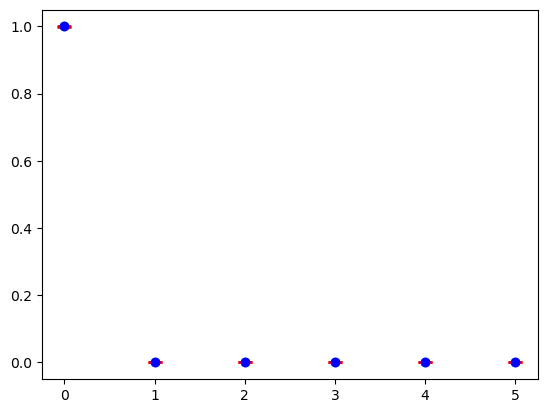

In [24]:
## Génération de $N$ valeurs finaux de $X$ pour chaque k
probas = np.bincount(cardinaux, minlength = n+1)/N
q = stats.norm.ppf(0.95)
var = q *np.sqrt(probas*(1-probas))/np.sqrt(N)
plt.scatter(np.arange(n+1), probas)
plt.errorbar(np.arange(n+1),probas, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.plot()
print('Probabilités', dict(zip(np.arange(n+1), probas)))
print('Longueur des intervalles de confiance', dict(zip(np.arange(n+1), var)))

### $\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

In [25]:
##Simulation de nbr*N_reduit simulations
alphas = np.linspace(0.99, 1, num = 10)
nbr = 10
varL = np.full((nbr, alphas.shape[0]),0)
cvarL = np.full((nbr, alphas.shape[0]),0)
for nb in range(nbr):
    echantillons = gen_X_particulier(X_0,N)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    impacts = vectorized_impact(echantillons, insolvances)
    for i in range(len(alphas)):
        alpha = alphas[i]
        var, cvar = calculate_var_cvar(impacts, alpha)
        varL[nb,i] = var
        cvarL[nb,i] = cvar

[]

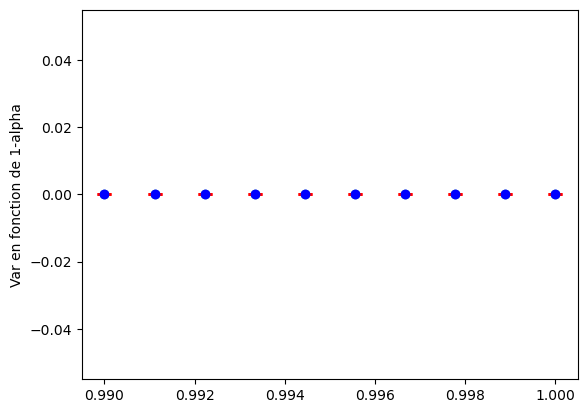

In [26]:
varA = np.mean(varL,axis = 0)
varvar = np.var(varL, axis =0)
plt.scatter(alphas, varA)
plt.errorbar(alphas,varvar, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.ylabel('Var en fonction de 1-alpha')
plt.plot()

[]

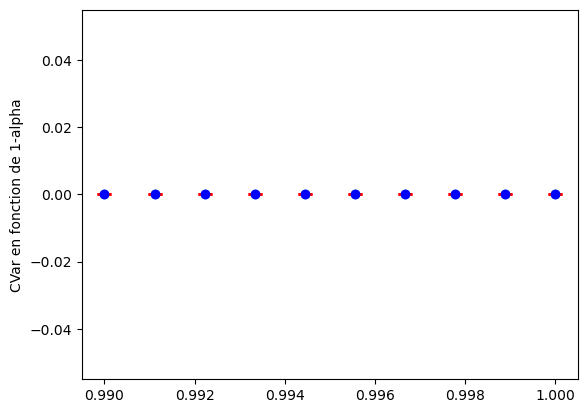

In [27]:
cvarLA =np.mean(cvarL,axis = 0)
varvarLA = np.var(cvarL, axis =0)
plt.scatter(alphas, cvarLA)
plt.errorbar(alphas,varvarLA, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.ylabel('CVar en fonction de 1-alpha')
plt.plot()


### $\to$ Estimation de la distribution de $I(T)$ conditionellement à un risque systèmique

In [7]:
## Distribution de I(T) condtionnelle
echantillons = gen_X_particulier(X_0,10*N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
impacts = vectorized_impact(echantillons, insolvances)
dist = impacts[cardinaux == n]

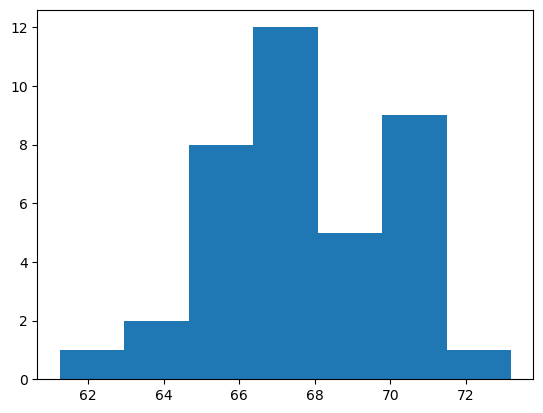

In [8]:
plt.hist(dist, bins='auto')
plt.show()

En ce basant sur ces résultats, la méthode de Monte Carlo $\textbf{n'est pas suffisante}$. Nous optons pour d'autre méthodes dite de réduction de variance, comme suit:

## $\blacktriangleright$ Échantillonage d'importance (Importance sampling)

L'idée est utiliser l'échantillonage par importance avec une distribution de telle manière à augmenter la probabilité que $|D_n^T|$ prennent des valeurs elevées, on propose de réduire $\mu$ en $\mu'$ de telle manière qu'il y'a plusieurs fois la réalisation de $X_i\leq c_i$. On pose alors:
$$X' \hookrightarrow \mathcal{N}\bigg(\mu' I_n, \dfrac{\delta \sigma^2}{1- e^{-2\lambda \delta}} (1- e^{-\lambda T}) I_n\bigg) $$

### $\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$.

On note $f^n_{\mu, \sigma}$ la densité de la loi $\mathcal{N}(\mu I_n, \sigma^2 I_n)$. On a alors:
$$\textbf{P}(|D_n^T| = k) = \textbf{E}_X\bigg[\textbf{1}_{|D_n^T|(X) = k}\bigg] =  \textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \dfrac{f^n_{\mu, \sigma_N}(X)}{f^n_{\mu', \sigma_N}(X')}\bigg]=\textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \cdot \text{exp}\bigg(\dfrac{\sum_{i=1}^n (X'_i-\mu')^2 -(X'_i-\mu)^2  )}{2\sigma_N^2}\bigg)\bigg]$$

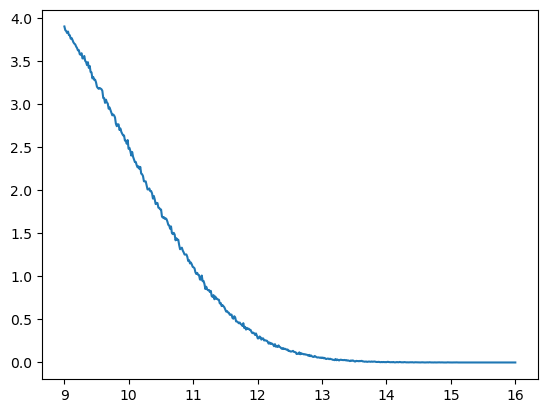

In [45]:
### Recherche empirique d'un mu prime optimal
mu_primes = np.linspace(min(C)-1,mu+1,num = 500 )
d_mu_p = np.full_like(mu_primes,0) 
cards = np.full_like(mu_primes,0) 
for i in range(len(mu_primes)):
    mu_prime = mu_primes[i]
    Xp_0 =np.full(n,mu_prime)
    echantillons = gen_X_particulier(Xp_0,10000)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
    d_mu_p[i] = np.mean(cardinaux)
    cards[i] = len(np.unique(cardinaux))/(n+1)
plt.plot(mu_primes, d_mu_p)
plt.show()

On prend $\mu' = 12$. On envisage le problème calculatoire suivant:

In [252]:
mu_p=12.
Xp_0 =np.full(n,mu_p)
echantillons = gen_X_particulier(Xp_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux  = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
classes = np.full(n+1,0.0)
for i in range(echantillons.shape[0]):
    try:
        #print(np.exp(np.sum((echantillons[i] - mu_p)**2 -(echantillons[i] - mu)**2 )))
        classes[cardinaux[i]]+= np.exp(np.sum((echantillons[i] - mu_p)**2 -(echantillons[i] - mu)**2 ))
    except OverflowError:
        print("Problème de débordement de mémoire")
        break
print(classes/N)

[2.12447263e+10 3.93691880e-04 1.59741320e-10 1.58818974e-11
 3.13120668e-11 8.62338898e-03]


On a ainsi des $\textbf{problèmes calculatoires et de débordement de mémoire}$ pour un importance sampling basé sur un changement de moyenne.

Du aux erreurs d'arrondis, nous avons décidé d'appliquer l'échantillonage d'importance à la variance au lieu de la moyenne 

On pose alors:
$$X' \hookrightarrow \mathcal{N}\bigg(\mu I_n, (\sigma_N')^2\bigg) \text{ avec }\sigma_N'^2 = \sigma_N^2 + \Delta \sigma^2 $$ 
On note $f^n_{\mu, \sigma}$ la densité de la loi $\mathcal{N}(\mu I_n, \sigma^2 I_n)$. On a alors:
$$\textbf{P}(|D_n^T| = k) = \textbf{E}_X\bigg[\textbf{1}_{|D_n^T|(X) = k}\bigg] =  \textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \dfrac{f^n_{\mu, \sigma_N}(X)}{f^n_{\mu, \sigma_N'}(X')}\bigg]=\sqrt{\dfrac{(\sigma_N')^2}{\sigma_N^2}}^5\textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \cdot \text{exp}\bigg(-\sum_{i=1}^n (X'_i-\mu)^2  \bigg(\dfrac{1}{2\sigma_N^2} - \dfrac{1}{2\sigma_N'^2}\bigg)\bigg]$$

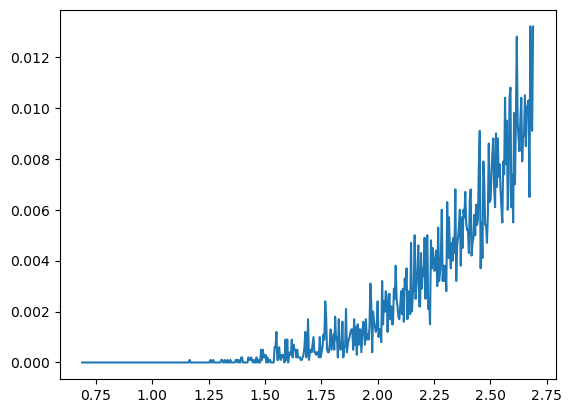

In [122]:
### Recherche empirique d'un sigma_2_p optimal
sigma_primes_2 = np.linspace(sigma_2-1,sigma_2+1,num = 500 )
d_sigma_primes_2 = np.full_like(sigma_primes_2,0) 
cards = np.full_like(sigma_primes_2,0) 
for i in range(len(sigma_primes_2)):
    sigma_prime  = sigma_primes_2[i]
    echantillons = gen_X_particulier(X_0,10000, sigma_2 = sigma_prime)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
    d_sigma_primes_2[i] = np.mean(cardinaux)
    cards[i] = len(np.unique(cardinaux))/(n+1)
plt.plot(sigma_primes_2, d_sigma_primes_2)
plt.show()

In [354]:
sigma_primes_2 = np.linspace(sigma_2-1,sigma_2+3,num = 150 )
var = np.full_like(sigma_primes_2,0) 
for i in range(len(sigma_primes_2)):
    sigma_prime  = sigma_primes_2[i]
    facteur = 1 / sigma_prime - 1 / sigma_2
    echantillons = gen_X_particulier(X_0,100000, sigma_2 = sigma_prime)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
    applique = cardinaux*np.exp(0.5 * facteur * np.sum((echantillons - mu)**2,axis = 1))
    var_ = np.std(applique)
    var[i] = var_

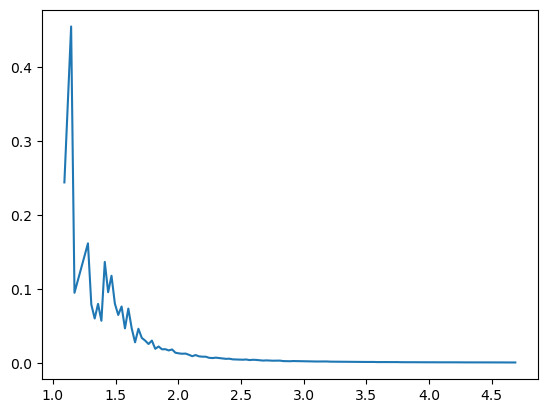

In [368]:
plt.plot(sigma_primes_2[(var>0) & (var<0.5)], var[(var>0) & (var<0.5)])
plt.show()

On prend $\Delta \sigma^2 = 2 $.

Probabilités {0: 0.9960234155447706, 1: 0.00024122760734418026, 2: 1.3593415139614857e-05, 3: 4.432055756379051e-06, 4: 2.6441658541480347e-06, 5: 4.393529746540178e-05}
Longueur des intervalles de confiance {0: 0.0003273536112220655, 1: 8.07771215364397e-05, 2: 1.9177350029901652e-05, 3: 1.095037273089245e-05, 4: 8.458065205541903e-06, 5: 3.447660568018328e-05}


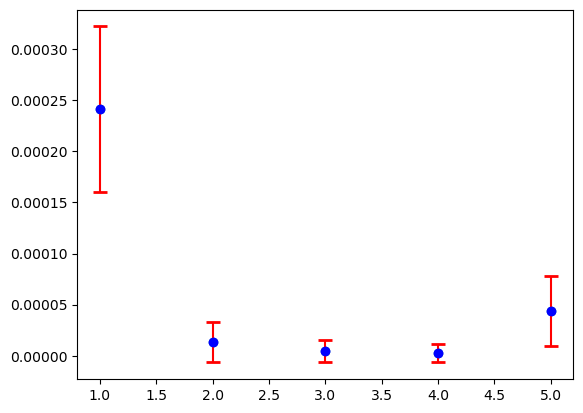

In [133]:
sigma_p = sigma_2 + 2
facteur = 1 / sigma_p - 1 / sigma_2
probas = np.zeros(n + 1)
X= gen_X_particulier(X_0,N,sigma_2 = sigma_p)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E, v, C, R), axis=1, arr=X)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis=1, arr=insolvances)
for k in range(X.shape[0]):
    r = cardinaux[k]
    probas[r] += np.exp(0.5 * facteur * np.sum((X[k] - mu)**2))
adjustment_factor = (sigma_p / sigma_2)**(5 / 2)
probas = adjustment_factor * probas / X.shape[0]
q = stats.norm.ppf(0.95)
var = q *np.sqrt(np.abs(probas*(1-probas)))/np.sqrt(N)
plt.scatter(np.arange(1,n+1), probas[1:])
plt.errorbar(np.arange(1,n+1),probas[1:], yerr=var[1:], fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.plot()
print('Probabilités', dict(zip(np.arange(n+1), probas)))
print('Longueur des intervalles de confiance', dict(zip(np.arange(n+1), var)))

[]

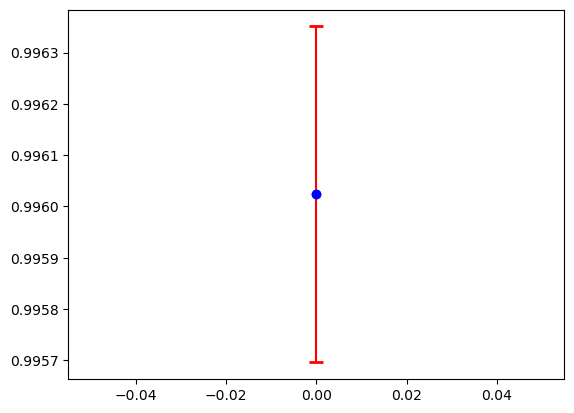

In [134]:
plt.scatter(0, probas[0])
plt.errorbar(0,probas[0], yerr=var[0], fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.plot()


### $\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

Pour cela on approche pour $x\in \textbf{R}$, la fonction répartition de $I(T)$ en $x$:
$$\textbf{P}(I(T)\leq x) = \sqrt{\dfrac{(\sigma_N')^2}{\sigma_N^2}}^5\textbf{E}_{X'}\bigg[\textbf{1}_{I(T) \leq x} \cdot \text{exp}\bigg(-\sum_{i=1}^n (X'_i-\mu)^2  \bigg(\dfrac{1}{2\sigma_N^2} - \dfrac{1}{2\sigma_N'^2}\bigg)\bigg)\bigg]$$

On remarque aussi que:
$$0\leq I(T) \leq\sum_{j=1}^n X_j(T) + \sum_{i,j}(1-R)E_{i,j}$$
Avec:

In [419]:
(1-R)*np.sum(E)

32.3

On déduit que dans notre cas:
$$0 \leq I(T) \leq \sum X_j(T) + 33 \sim \mathcal{N}(108, 8)$$
On déduit que:
$$I(T) \in [0, 108 + 8\cdot 2,62]  \subset [0,130] \text{ à probabilité }0.99  $$

In [77]:
sigma_p = sigma_2 + 2
facteur = 1 / sigma_p - 1 / sigma_2
adjustment_factor = (sigma_p / sigma_2)**(5 / 2)
X= gen_X_particulier(X_0,int(1e7),sigma_2 = sigma_p)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E, v, C, R), axis=1, arr=X)
impacts=vectorized_impact(X, insolvances)
ex = np.apply_along_axis(lambda v: np.exp(np.sum((v-mu)**2) *facteur) , axis=1, arr=X)

In [78]:
X_, indices = np.unique(impacts, return_index=True)
X_.sort()
f_X = np.full_like(X_,0)
i_ = impacts.copy()
i_.sort()

228032
[7.57600920e-04 5.76403181e-01 2.77497935e-01 ... 2.00336238e-02
 5.46057563e-05 2.77338555e-02]


In [109]:
print(len(X_))
current = 0
i =0
j=0
j_max = 0
while ((i<len(i_)-1) & j<len(X_)-1):
    try:
        x=X_[j]
        while(i_[i]<x):
            current+=adjustment_factor*ex[i]
            i=i+1
        f_X[j]=current/len(i_)
        j=j+1
    except:
        j_max = j
        break
X_ = X_[:j_max]
f_X = f_X[:j_max]

228032


In [110]:
f_X= f_X/np.max(f_X)

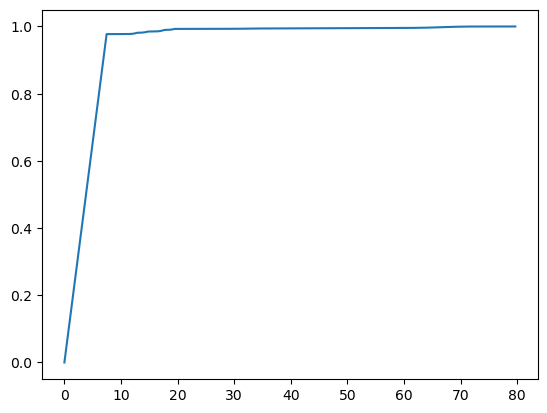

In [111]:
plt.plot(X_,f_X)

On déduit la VaR comme suit:

In [118]:
alphas = np.linspace(0.95,1,num = 10,endpoint = False)
vars_ = np.full_like(alphas,0)
for i in range(len(alphas)):
    alpha = alphas[i]
    for j in range(len(f_X)):
        if f_X[j]>alpha:
            vars_[i] =X_[j]
            break

[]

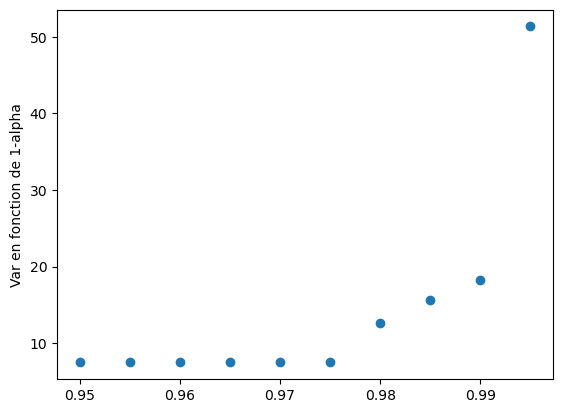

In [120]:
plt.scatter(alphas, vars_)
plt.ylabel('Var en fonction de 1-alpha')
plt.plot()

### $\to$ Estimation de la distribution de $I(T)$ conditionellement à un risque systèmique

On écrit:
$$\forall x\in \textbf{R}: \textbf{P}(I(T)\leq x \text{ | }\mathcal{F}) = \dfrac{\textbf{P}(I(T) \leq x \text{ , }\mathcal{F})}{\textbf{P}(\mathcal{F})} \text{ où on a estimé } \textbf{P}(\mathcal{F}) =3.44\cdot 10^{-5} $$
Et:
$$\textbf{P}(I(T)\leq x \text{ , }\mathcal{F})= \sqrt{\dfrac{(\sigma_N')^2}{\sigma_N^2}}^5\textbf{E}_{X'}\bigg[\textbf{1}_{I(T) \leq x}\textbf{1}_{X\in \mathcal{F}} \cdot \text{exp}\bigg(-\sum_{i=1}^n (X'_i-\mu)^2  \bigg(\dfrac{1}{2\sigma_N^2} - \dfrac{1}{2\sigma_N'^2}\bigg)\bigg)\bigg]$$

In [124]:
X_, indices = np.unique(impacts, return_index=True)
X_.sort()
f_X = np.full_like(X_,0)
i_ = impacts.copy()
args=np.argsort(impacts)
i_.sort()
print(len(X_))
current = 0
i =0
j=0
j_max = 0
while ((i<len(i_)-1) & j<len(X_)-1):
    try:
        x=X_[j]
        while(impacts[args[i]]<x):
            current+=adjustment_factor*ex[i]*np.sum(insolvances[args[i]])
            i=i+1
        f_X[j]=current/len(i_)
        j=j+1
    except:
        j_max = j
        break
X_ = X_[:j_max]
f_X = f_X[:j_max]

228032


Text(0.5, 1.0, 'Foncton de répartition de $I(T)$ conditionelle')

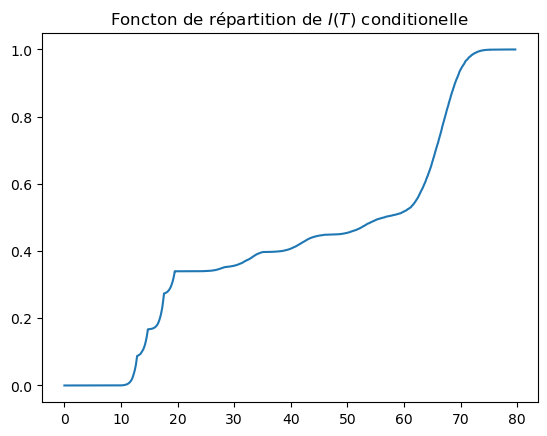

In [126]:
f_X= f_X/np.max(f_X)
plt.plot(X_,f_X)
plt.title("Foncton de répartition de $I(T)$ conditionelle")

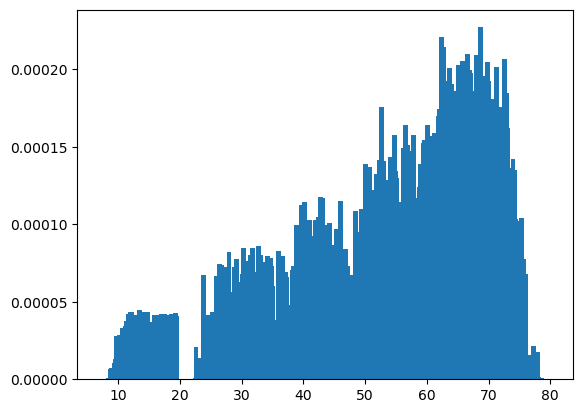

In [132]:
bin_heights = [f_X[i+1]-f_X[i] for i in range(len(f_X)-1)]
plt.bar(X_[1:], bin_heights)
plt.show()

On comparera ce résultat avec une implementation numérique (ci-dessous) basé sur les graphes qui est exacte.

## $\blacktriangleright$ Méthode de splitting

On se sert de la méthode de splitting qui est une sorte de 'diviser pour regner'. On utilise la formule de Bayes comme suit:
$$\textbf{P}(I(T)> q = q_r) = \prod_{i=0}^{r-1}\textbf{P}(I(T)>q_{i+1}|I(T)>q_i) \text{ avec }q_0 = -\infty$$
L'avantage de cette méthode est que l'on peut controller que:
$$\textbf{P}(I(T)>q_{i+1}|I(T)>q_i)\simeq \varepsilon \text{ un seuil fixé  tel que }\textbf{P}(I(T)> q = q_r)  \simeq \varepsilon^r \text{ où }r \text{ le nombre de splits} $$

Pour le calcul d'intervalles de confiance, on se sert du lemme suivant:

$\textbf{Lemme:}$ Soit $Y_1,\cdots, Y_N$ des variables aléatoires et  $(I_1^p, \cdots I_N^p)_{p\geq 1}$ tel que pour tout $k\in \{1,\cdots , N\}$, on a: 

$$p_k^N = \textbf{P}(Y_k\in I_k^p)\xrightarrow[p\to +\infty]{}1$$


Soit $f\in \mathcal{C}^0(\textbf{R}^N, \textbf{R})$ et $Z= f(Y_1,\cdots,Y_N)$, alors:


$$p_Z^p = \textbf{P}(Z\in f(I_1^p\cdots,I_N^p ))\xrightarrow[p\to +\infty]{}1$$

On compare l'efficacité de cette méthode face au MC naif:

In [133]:
#Paramètre de splitting
a=10
rho=0.5
rho_bar=np.sqrt(1-rho**2)
M=20
m=15
sigma=np.sqrt(sigma_2)
seuil=0.1
niveaux,plast = NiveauxSplitting(a, seuil ,20, C , E, rho, N, R)
print("Nombre de niveaux = {}:".format(len(niveaux)-1)) 
Proba_emp_split=plast*seuil**(len(niveaux)-1)

# estimation par Monte-Carlo naif
X = gen_X_particulier(X_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
impacts = vectorized_adapted_impact(X, insolvances)
Proba_emp_MonteCarlo=np.mean(impacts>a)
print("Splitting fournit la probabilité = {:1.3e}".format(Proba_emp_split))
print("Monte-Carlo naif fournit = {:1.3e}".format(Proba_emp_MonteCarlo))

Nombre de niveaux = 4:
Splitting fournit la probabilité = 5.646e-05
Monte-Carlo naif fournit = 5.200e-04


On obtient une fonction de répartition empirique:

In [137]:
def RepEmpirique(x):
    niveaux,plast = NiveauxSplitting(x, seuil ,20, C , E, rho, N, R)
    return 1 - plast*seuil**(len(niveaux)-1)
bin_edges = np.linspace(min(C), 100,num = 10) 

RepEmpirique(50)

KeyboardInterrupt: 

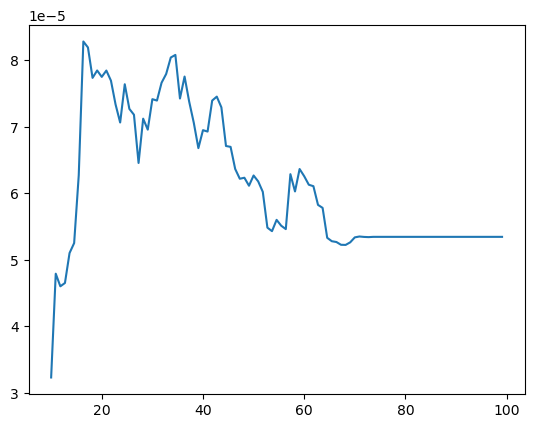

In [186]:
cum_sim = np.cumsum(bin_heights)
plt.plot(bin_edges[:-1],cum_sim)

## $\blacktriangleright$ Usage de graphes pour $I(T) | \mathcal{F}$

In [202]:
###Fonctions utiles
def check_matrix(M,E):
    for i in range(M.shape[0]):
        arg = np.argwhere(M[i]>0)
        if len(arg)==0:
            continue
        else:
            if E[arg[0][0]][i]>0:
                
                continue
            else: 
                return False
    return True
def matrix_to_I(M, E, C, R=0.05, n=5):
    if not check_matrix(M, E):
        raise Exception("Matrices non compatibles")
    
    I = np.zeros(n)
    L = [[] for _ in range(n)]
    count = 0
    
    while count < n:
        for k in np.argwhere(I == 0):
            i = k[0]
            if len(np.argwhere(M[i] > 0)) == 0:
                L[i].append(i)
                I[i] = C[i]
                count += 1
            else:
                arg = np.argwhere(M[i] > 0)[0]
                if I[arg] == 0:
                    continue
                else:
                    L[i] = L[arg[0]].copy()
                    L[i].append(i)
                    r = C[i] + (1 - R) * np.sum([E[i][k] for k in L[i]])
                    I[i] = r
                    count += 1
    
    return np.array([(0,k) for k in I])

### $\to$ Modélisation en graphes et exemples

On remarque qu'une risque systémique souvent se passe par une sucession d'insolvances qu'on peut modéliser par des graphes. Par exemple, un tel scénario étant donné notre matrice est le suivant:
$$1 \to 5 \to\begin{cases}
3\\
2\\
4\\
\end{cases} \text{ ou bien }\begin{cases}
1\to 2\\
4\to \begin{cases}
5\\
3
\end{cases}
\end{cases}$$
Les différents cas possibles sont prédeterminé grace à la structure de la matrice $E$. Par exemple pour la matrice suivante:

$$
E = \begin{pmatrix}
0 & 3 & 0 & 0 & 0\\
4 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 5\\
0 & 0 & 0 & 2 & 0\\
\end{pmatrix}
$$
On a, avec défaillance de la banque 3, les seuls cas de figure suivants:
$$\mathcal{C}_1:\begin{cases}
1\to 2\\
4\to 5
\end{cases} \text{ ou }
\mathcal{C}_2:
\begin{cases}
1\to 2\\
5\to 4
\end{cases}
\text{ ou }
\mathcal{C}_3:
\begin{cases}
2\to 1\\
4\to 5
\end{cases}
\text{ ou }
\mathcal{C}_4:
\begin{cases}
2\to 1\\
5\to 4
\end{cases}$$
Les cas où on a des défaillances simultanés (par exemple $1 \text{ et } 2$) sont inclus dans le cas de défaillances successives ($X_i<C_i\implies X_i<C_i +(1-R)E_{i,j}$).


L'idée cruciale sur laquelle se base l'étude suivante est qu'on a équivalence d'un cas $\mathcal{C}_i$ et le fait que $(X_1(T),\cdots,X_n(T))\in \mathcal{I}_{\mathcal{C}_i}$ où l'on construit $\mathcal{I}_{\mathcal{C}_i}$ de près en près (voir fonction matrix_to_I). On commence par déterminer les parents $p$ de chaques composante connexe de graphe, on pose $I^p = c_p$ (la borne sur la variable $X_p$), puis on parcours les graphes, on pose $I^p = c_p + (1-R)\sum_{j\in \text{Chemin menant à i}}e_{p,j}$. On obtient, un intervalle:


$$I_{\mathcal{C}_i} = [0,I^1]\times \cdots \times [0,I^n]$$

On code tous les chemins de défaillance possibles par des matrices $G$ à valeurs dans $\mathcal{M}_n(\{0,1\})$ où pour la $i-$ème ligne, on a un unique $j\neq i$ tel que $G_{i,j} =1$ si la valeur $i$ admet un parent dans le graphe, sinon que des zéros.

Par exemple:
$$\mathcal{C}_4:
\begin{cases}
2\to 1\\
5\to 4
\end{cases} \equiv G(\mathcal{C}_4) = \begin{pmatrix}
0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0\\
\end{pmatrix}$$
Dans ce cas, le calcul ci-dessous fournit:


$$I_{\mathcal{C}_4}  = [0,12.85]\times[0,10]\times [0,10]\times [0,15.7]\times [0,11.9]$$


Avec un seuil fixe de $10$ et taux d'amortissement $R= 0.05$

In [178]:
A =np.array([[0,3,0,0,0],
           [4,0,0,0,0],
           [0,0,0,0,0],
           [0,0,0,0,5],
           [0,0,0,2,0]])
example= np.array([[0,1,0,0,0],
                  [0,0,0,0,0],
                  [0,0,0,0,0],
                  [0,0,0,0,1],
                  [1,0,0,0,0]])
L=matrix_to_I(example,E,C,R,n)

array([ 0.  , 12.85])

Le calcul de la probabilité de cet intervalle est aisé vu le fait qu'on sait calculer $\textbf{P}(\mathcal{N}(\mu,\sigma^2)\in [0,I^p]) = F(I^p;\mu,\sigma^2) -F(0;\mu,\sigma^2)$. On obtient alors la valeur exacte(les variables supposés independants):
$$\textbf{P}(I_{\mathcal{C}_i}) = 1.055 \cdot 10^{-12}$$
Avec une simulation Monte-Carlo, on aurait besoin d'environ $10^{13}$ simulations. En supposant qu'on code une simulation en $\texttt{float64}$, une simulation prend environ $0.0078125kB$, soit pour $10^{13}$ simulation, environ $74Gb$ de mémoire simultanée.

In [101]:
sigma = np.sqrt(sigma_2)
prob_1 = norm.cdf(12.85, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob_2 = norm.cdf(10, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob_3 = norm.cdf(10, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob_4 = norm.cdf(15.7, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob_5 = norm.cdf(11.9, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob = prob_1 * prob_2 * prob_3 * prob_4 * prob_5
print(prob)

1.0550305782723682e-12


### $\to$ Géneration des graphes/intervalles nécessaires

In [226]:
###Fonctions auxiliaires
def generate_matrices(E):
    W=E>0
    n = W.shape[0]
    indices = [np.append(np.where(W[i] == 1)[0], -1) for i in range(n)]
    
    
    all_combinations = product(*indices)
    
    matrices = []
    for combination in all_combinations:
        matrix = np.zeros_like(W)
        for i, j in enumerate(combination):
            if j != -1:  # -1 signifie que cette ligne ne prendra que des 0 
                matrix[i, j] = 1
        matrices.append(matrix)
    
    return matrices
def is_cyclic_util(graph, v, visited, parent):
    visited[v] = True

    for i in range(len(graph)):
        if graph[v][i] == 1:  # Si v est connecté à i
            if not visited[i]:  # Si i n'a pas été visité
                if is_cyclic_util(graph, i, visited, v):
                    return True
            elif parent != i:  # Si i est visité et n'est pas le parent de v
                return True

    return False

def is_cyclic(graph):
    visited = [False] * len(graph)
    for i in range(len(graph)):
        if not visited[i]:  
            if is_cyclic_util(graph, i, visited, -1):
                return True

    return False
def check_acyclic(M):
    for i in range(M.shape[0]):
        arg = np.argwhere(M[i]>0)
        if len(arg)==0:
            continue
        else:
            k = arg[0][0]
            arg_p = np.argwhere(M[k]>0)
            if (len(arg_p) == 0):
                continue
            else:
                l= arg_p[0][0]
                if l == i:
                    return False
    return True
def I_to_prob(interval,mu = 15,sigma_2 = 1.68):
    sigma = np.sqrt(sigma_2)
    prod =1
    for i in range(len(interval)):
        prob_ = norm.cdf(interval[i][1], loc=mu, scale=sigma) - norm.cdf(interval[i][0], loc=mu, scale=sigma)
    prod = prod*prob_
    return prod

In [62]:
print(E)

[[0 3 0 0 6]
 [3 0 0 0 0]
 [3 3 0 0 0]
 [2 2 2 0 2]
 [0 2 3 3 0]]


In [133]:
vectorized=np.vectorize(is_cyclic)
matrices = generate_matrices(E.T)
matrices_acycliques_p=[matrix.astype(int) for matrix in matrices if not is_cyclic(matrix)]
matrices_acycliques = [matrix for matrix in matrices_acycliques_p if check_acyclic(matrix)]
print('Exemples de matrices:')
count = 0
for idx, matrix in enumerate(matrices_acycliques):
    if count==3:
        break
    count+=1
    print(f"Matrice de chemin {idx+1}:\n{matrix}\n")

Exemples de matrices:
Matrice de chemin 1:
[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]

Matrice de chemin 2:
[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

Matrice de chemin 3:
[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 1 0]]



In [210]:
### Generation des intervalles
I = []
for matrice in matrices_acycliques:
    I.append(matrix_to_I(matrice,E,C))
print("Exemples d'intervalles: " , I[:2])
I_list = [[list(y)for y in x ] for x in I]

Exemples d'intervalles:  [array([[ 0.  , 18.55],
       [ 0.  , 10.  ],
       [ 0.  , 10.  ],
       [ 0.  , 11.9 ],
       [ 0.  , 10.  ]]), array([[ 0.  , 12.85],
       [ 0.  , 10.  ],
       [ 0.  , 10.  ],
       [ 0.  , 10.  ],
       [ 0.  , 10.  ]])]


In [213]:
### Cleaning des intervalles
def get_cut_points(intervals):
    points = set()
    for interval in intervals:
        points.add(interval[0])
        points.add(interval[1])
    return sorted(points)

def partition_intervals(intervals):
    points = get_cut_points(intervals)
    partitioned_intervals = []
    for i in range(len(points) - 1):
        partitioned_intervals.append([points[i], points[i + 1]])
    return partitioned_intervals

def combine_partitions(partitions):
    from itertools import product
    return list(product(*partitions))

def interval_overlap(interval1, interval2):
    return max(interval1[0], interval2[0]) < min(interval1[1], interval2[1])

def hyperrectangle_overlap(hr1, hr2):
    return all(interval_overlap(hr1[i], hr2[i]) for i in range(5))

def is_in_union(hyperrect, union_hyperrects):
    for uhr in union_hyperrects:
        if hyperrectangle_overlap(hyperrect, uhr):
            return True
    return False

def partition_hyperrectangles(hyperrectangles):
    # Collect all intervals for each dimension
    dimensions = len(hyperrectangles[0])
    all_intervals = [[] for _ in range(dimensions)]
    
    for hyper in hyperrectangles:
        for i in range(dimensions):
            all_intervals[i].extend([hyper[i]])

    # Partition each dimension
    partitioned_intervals = [partition_intervals(intervals) for intervals in all_intervals]

    # Combine partitions to create all potential hyperrectangles
    potential_hyperrects = combine_partitions(partitioned_intervals)

    # Filter to only include those within the union of the original hyperrectangles
    disjoint_hyperrectangles = []
    for hr in potential_hyperrects:
        if is_in_union(hr, hyperrectangles):
            disjoint_hyperrectangles.append(hr)

    return disjoint_hyperrectangles

# Exemple d'utilisation
hyperrectangles =I_list

result = partition_hyperrectangles(hyperrectangles)
for hyper in result:
    print(hyper)


([0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0])
([0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [10.0, 12.85])
([0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [10.0, 11.9], [0.0, 10.0])
([10.0, 12.85], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0])
([10.0, 12.85], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [10.0, 12.85])
([10.0, 12.85], [0.0, 10.0], [0.0, 10.0], [10.0, 11.9], [0.0, 10.0])
([12.85, 15.7], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0])
([12.85, 15.7], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [10.0, 12.85])
([12.85, 15.7], [0.0, 10.0], [0.0, 10.0], [10.0, 11.9], [0.0, 10.0])
([15.7, 18.549999999999997], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0])
([15.7, 18.549999999999997], [0.0, 10.0], [0.0, 10.0], [0.0, 10.0], [10.0, 12.85])
([15.7, 18.549999999999997], [0.0, 10.0], [0.0, 10.0], [10.0, 11.9], [0.0, 10.0])


### $\to$ Simulation de risque systèmique

On écrit alors l'evenement faillite comme suit:
    $$\mathcal{F} = \{X=(X_1(T),\cdots,X_n(T))\text{ , }\exists \mathcal{C}: X\in I_\mathcal{C}\}$$
    
En notant $\mathcal{I} = \{I_1,\cdots, I_M\}$ l'ensemble des intervalles possibles (listes), on simule une variable indice $L\in[|1,M|]$ avec probabilité:
$$\textbf{P}(L = l) = \dfrac{\textbf{P}(I_l)}{\sum_{p=1}^M \textbf{P}(I_p)}$$

On se fixe alors l'intervalle $I_L$, on simule alors $X_*^L \sim \mathcal{N}(\mu,\sigma^2)|\mathcal{N}(\mu,\sigma^2)\in I_L$. En effet, en général pour $z_0\leq z_1$:
$$Z\sim\mathcal{N}(\mu,\sigma^2) \text{  }|\text{  } z_0\leq \mathcal{N}(\mu,\sigma^2)\leq z_1 $$
À pour densité:
$$\forall z\in \textbf{R}:f_Z(z) = \dfrac{\text{exp}\big(-(z-\mu)^2/(2\sigma^2)\big)\textbf{1}_{z\in[z_0,z_1]}}{\sqrt{2\pi}\sigma(\text{F}(z_1;\mu,\sigma) - \text{F
}(z_0;\mu,\sigma))}$$
En notant $I_L=[0,I_L^1]\times \cdots \times [0,I_L^n]$, on déduit:
$$\forall x=(x_1,\cdots,x_n)\in\textbf{R}^n: f_{X_*^L}(x_1,\cdots,x_n) = \bigg(\prod_{p = 1}^n \dfrac{1}{\sqrt{2\pi}\sigma(F(I_L^p;\mu,\sigma)-F(0;\mu,\sigma))}\bigg)\text{exp}\bigg(-\dfrac{||x-\mu||^2}{2\sigma^2}\bigg)\textbf{1}_{x\in I_L}$$
Soit:
$$\forall x=(x_1,\cdots,x_n)\in\textbf{R}^n: f_{X_*^L}(x_1,\cdots,x_n) = \dfrac{1}{\sqrt{(2\pi}\sigma)^n \textbf{P}(I_L)}\text{exp}\bigg(-\dfrac{||x-\mu||^2}{2\sigma^2}\bigg)\textbf{1}_{x\in I_L}$$

In [228]:
### Calcul de probabilité des intervalles

probas = np.array([I_to_prob(inv) for inv in result])
probas = probas/np.sum(probas)
choix = np.arange(0,len(result))

### $\to$ Distribution de l'impact conditionnelle à $\mathcal{F}$

En général, on écrit:
    $$ I(T) = \sum_{i\in D_n^T}X_i(T)+\sum_{j\not \in D_n^T}(1-R)e_{i,j} = \sum_{A\subset\{1,\cdots,n\}}\bigg(\sum_{i\in A}X_i(T)+\sum_{j\not \in A}(1-R)e_{i,j}\bigg)\textbf{1}_{D_n^T = A}$$
La faillite correspond à exactement $A=[|1,n|]$, on a alors:
$$\forall c\in \textbf{R}: \textbf{P}(I(T)>c|\mathcal{F}) = \textbf{P}\bigg(\sum_{k=1}^nX_k(T)\text{ }\bigg|\text{ }\mathcal{F}\bigg)$$

In [245]:
### Calcul de distribution
N_p = 100000
choix_I = random.choices(choix, probas,k=N_p)
mu = 15
impacts = []
sigma = np.sqrt(sigma_2)    
for i in choix_I:
    L = result[i]
    s= 0
    
    for k in range(len(L)):
        lower_bound = L[k][0]
        upper_bound = L[k][1]
        a = (lower_bound - mu) / sigma
        b = (upper_bound - mu) / sigma
        s += truncnorm.rvs(a, b, loc=mu, scale=sigma)
    impacts.append(s)


[]

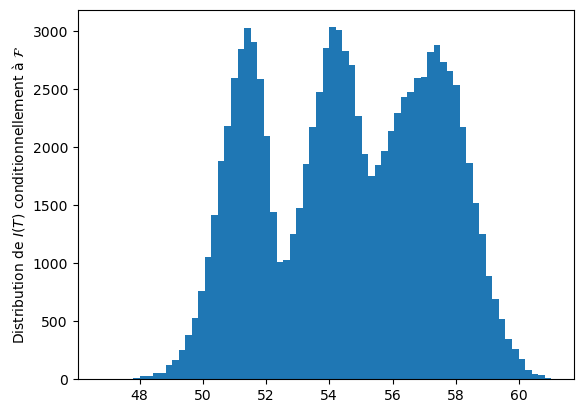

In [248]:
plt.hist(impacts, bins='auto')
plt.ylabel('Distribution de $I(T)$ conditionnellement à $\mathcal{F}$')
plt.plot()

## $\blacktriangleright$ Étude de la convergence de quantile

On reprend l'expression:
$$ I(T) = \sum_{i\in D_n^T}X_i(T)+\sum_{j\not \in D_n^T}(1-R)e_{i,j} = \sum_{A\subset\{1,\cdots,n\}}\bigg(\sum_{i\in A}X_i(T)+\sum_{j\not \in A}(1-R)e_{i,j}\bigg)\textbf{1}_{D_n^T = A}$$
On écrit pour $A\subset \{1,\cdots,n\}$ non vide:
$$I_A(T) =  \sum_{i\in A}X_i(T)+\sum_{j\not \in A}(1-R)e_{i,j}$$
Pour $X\sim\mathcal{N}(\mu I_n,\sigma^2 I_n)$, $I_A(T) \sim \mathcal{N}(|A|\mu + \sum_{i\in A}\sum_{j\not \in A}(1-R)e_{i,j},|A|\sigma^2 )$ de densité:
$$\forall x\in \textbf{R}: f_A(x) = \dfrac{1}{\sqrt{2\pi|A|}\sigma}\text{exp}\bigg(-\dfrac{(x -\mu_A)^2}{2|A|\sigma^2}\bigg)\text{ avec }\mu_A=|A|\mu + \sum_{i\in A}\sum_{j\not \in A}(1-R)e_{i,j} $$
On remarque que:
$$\forall x\in \textbf{R}:\textbf{P}(I(T)\leq x) = \sum_{A \subset\{1,\cdots,n\}} \textbf{P}(I_A(T)\leq x)\textbf{P}(D_n^T =A)$$
La distribution de $I(T)$ est donc une mixture gaussienne et donc admet une densité qui s'ecrit:
$$\forall x\in \textbf{R}: f(x) = \sum_{A \subset\{1,\cdots,n\}} \textbf{P}(D_n^T =A)f_A(x)$$
On pose:
$$\forall x\in \textbf{R}:f_*(x) =\min_{A\subset \{1,\cdots,n\}}f_A(x) $$
Ainsi défini, on a sur un convexe compact $U\subset \textbf{R}$:
$$\forall x\in U: f(x) \geq \sum_{A\subset\{1,\cdots,n\},A \neq \phi}\textbf{P}(D_n^T =A)f_*(x) \geq (1- \textbf{P}(D_n^T = \phi))\min{t\in U}f_*(t) = K$$
Après intégration pour $x_0\in U$:
$$\forall x\in U: |F(x) - F(x_0)| \geq K |x-x_0|$$
On a alors , pour un estimateur de fonction de répartition:
$$\forall x\in U:\underbrace{||\hat{F}_p-F||_\infty}_{\xrightarrow[p\to+\infty]{p.s}0 \text{ par Glivenko-Cantelli}} +|\hat{F}_p(x) - F(x_0)|\geq K|x-x_0| $$
On a $\textbf{P}(D_n^T =\phi) = \textbf{P}(X\in [c_1,+\infty[\times \cdots \times[c_n,+\infty[) = \prod_{k=1}^n(1-F(c_k;\mu_k,\sigma_k))$ dont on peut calculer explicitement. On a aussi que:
$$\forall X:0\leq I(T) \leq \sum_{j=1}^n X_j(T) \sim \mathcal{N}(n\mu, n\sigma^2)$$
On déduit un intervalle de confiance à $1-\varepsilon$:
$$U = [0,n\mu +\sigma q_{1 - \varepsilon}] \text{ où }q_{1-\varepsilon} \text{ est la quantile }1-\varepsilon \text{  de la loi normale centrée réduite}$$

In [162]:
eps = 0.01
Q_eps = norm.ppf(1 - eps)
U_max = n*mu + np.sqrt(sigma_2)*Q_eps
print('U= [0',U_max,'] à probabilité ',1-eps)
sets= np.arange(1,n+1)
base= np.linspace(0,U_max,num = 100)
evals = []
for k in range(1,n):
    for i in combinations(sets, k):
        L = np.arange(1,n) in i
        mu_p = k*mu  + np.sum  # Mean
        sigma_p = np.sqrt(k*sigma_2)  # Standard Deviation
        pdf_values = norm.pdf(array, loc=mu, scale=sigma)
        res = np.

U= [0 78.02360097975932 ] à probabilité  0.99
(1,)
(2,)
(3,)
(4,)
(5,)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 3)
(2, 4)
(2, 5)
(3, 4)
(3, 5)
(4, 5)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 3, 4)
(1, 3, 5)
(1, 4, 5)
(2, 3, 4)
(2, 3, 5)
(2, 4, 5)
(3, 4, 5)
(1, 2, 3, 4)
(1, 2, 3, 5)
(1, 2, 4, 5)
(1, 3, 4, 5)
(2, 3, 4, 5)


In [168]:
L = np.arange(1,n)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### $\to$ Estimation de $K$